## Retaining Telcommunication Customers: "Using Data Science to Identify Churn Risks"

## Imports

In [204]:
# imports used 
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# import our own acquire module
import acquire
import prepare
import os
import env

# Acquire


 1. During the acquire phase of the messy_telco_df project:
 
        ◦ We obtained data from a CSV file stored on a remote server.
        We accessed the file using the pandas library and the read_csv() function.
        ◦ We accessed the file using the pandas library and the read_csv() function.
        ◦ The file contained data related to customers of a fictitious telecommunications company.

 2. The data was acquireds in March 2023:
 
        ◦ The size of the data was 7043 rows and 21 columns. Each observation in the data represented a unique customer of the telecommunications company.
        

 3. The columns in the data represented various information about each customer: 
 
        ◦ including demographic information (such as gender, age, and whether or not they had dependents), services they had subscribed to (such as internet, phone, and streaming TV), their payment and contract information, and whether or not they had churned (i.e. cancelled their service).company.

In [2]:
# Import acquired messy data from your acquire file here
df = acquire.get_telco_data()
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [3]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Prepare

1. Data understanding and exploration:
        ◦ Load the dataset and analyze its structure.
        ◦ Perform descriptive statistics and visualizations to understand the data distribution and relationships between features.
        
        
 2. Data preprocessing and feature engineering:
        ◦ Handle missing values.
        ◦ Encode categorical variables (e.g., using one-hot encoding or ordinal encoding).
        ◦ Scale or normalize numerical features, if necessary.
        ◦ Perform any necessary feature selection or feature extraction (e.g., using PCA or domain-specific knowledge).
        
3. Split the data:
        ◦ Split the dataset into training, validation, and test sets (e.g., using an 80/10/10 or 70/15/15 split).

In [4]:
def detect_column_types(df):
    """
    Returns a dictionary with column names grouped by their data types.
    """
    column_info = df.dtypes.groupby(df.dtypes).groups
    column_groups = {}
    for dtype, column_list in column_info.items():
        column_groups[dtype] = column_list.tolist()
    return column_groups

In [5]:
def clean_data(df):
    """
    Cleans the dataset by lowercase column names, removing nulls, and dropping unnecessary columns.
    """
    df = df.copy()
    df.columns = df.columns.str.lower()
    df = df.dropna()
    columns_to_drop = ['customerid']
    df.drop(columns_to_drop, axis=1, inplace=True)
    return df

In [6]:
def encode_categorical_columns(df, categorical_columns, encoding_method='ordinal'):
    """
    Encodes categorical columns using the specified encoding method.
    """
    if encoding_method == 'ordinal':
        encoder = OrdinalEncoder()
        df[categorical_columns] = encoder.fit_transform(df[categorical_columns])
    # Add other encoding methods if needed
    return df

In [7]:
def change_numerical_columns_datatype(df, numerical_columns, datatype='float64'):
    """
    Changes the datatype of numerical columns.
    """
    for column in numerical_columns:
        df[column] = df[column].astype(datatype)
    return df

In [8]:
def encode_binary_columns(df, columns, encoding_method='ordinal'):
    """
    Encodes binary columns using the specified encoding method.
    """
    if encoding_method == 'ordinal':
        for col in columns:
            unique_values = df[col].unique()
            value_map = {value: i for i, value in enumerate(unique_values)}
            df[col] = df[col].replace(value_map).astype(int)
    # Add other encoding methods as needed
    return df

In [9]:
def get_numerical_columns(df):
    """
    Returns a list of column names for numerical columns.
    """
    numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
    return numerical_columns

In [10]:
def get_categorical_columns(df):
    """
    Returns a list of column names containing categorical data in the given DataFrame.
    """
    object_columns = df.select_dtypes(include=['object']).columns.to_list()
    boolean_columns = df.select_dtypes(include=['bool']).columns.to_list()
    categorical_columns = object_columns + boolean_columns
    return categorical_columns

In [11]:
def prepare_telco_data(df):
    """
    Prepares the telco customer churn dataset for modeling by cleaning the data and encoding categorical and binary features.
    """
    # Clean the data
    df = clean_data(df)

    # Group columns by data types
    column_groups = detect_column_types(df)
    object_columns = column_groups[np.dtype('object')]
    int_columns = column_groups[np.dtype('int64')]
    float_columns = column_groups[np.dtype('float64')]

    # Identify binary, categorical, and numerical columns
    binary_columns = [col for col in object_columns if df[col].nunique() == 2]
    categorical_columns = [col for col in object_columns if df[col].nunique() > 2]
    numerical_columns = column_groups[np.dtype('int64')] + column_groups[np.dtype('float64')]

    # Encode categorical and binary columns
    df = encode_categorical_columns(df, categorical_columns)
    df = encode_binary_columns(df, binary_columns)

    # Change the datatype of numerical columns
    df = change_numerical_columns_datatype(df, numerical_columns)
    
    return df

In [12]:
prepare_telco_data(df)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,0,0.0,0,0,1.0,0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0,2.0,29.85,29.85,0
1,1,0.0,1,0,34.0,1,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,1,3.0,56.95,1889.50,0
2,1,0.0,1,0,2.0,1,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,3.0,53.85,108.15,1
3,1,0.0,1,0,45.0,0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,1,0.0,42.30,1840.75,0
4,0,0.0,1,0,2.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.0,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0.0,0,1,24.0,1,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,0,3.0,84.80,1990.50,0
7039,0,0.0,0,1,72.0,1,2.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,0,1.0,103.20,7362.90,0
7040,0,0.0,0,1,11.0,0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.0,29.60,346.45,0
7041,1,1.0,0,0,4.0,1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,74.40,306.60,1


In [13]:
# Prepare the dataset for modeling
df_clean = prepare_telco_data(df)

In [99]:
df_clean

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,0,0.0,0,0,1.0,0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0,2.0,29.85,29.85,0
1,1,0.0,1,0,34.0,1,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,1,3.0,56.95,1889.50,0
2,1,0.0,1,0,2.0,1,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,3.0,53.85,108.15,1
3,1,0.0,1,0,45.0,0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,1,0.0,42.30,1840.75,0
4,0,0.0,1,0,2.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.0,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0.0,0,1,24.0,1,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,0,3.0,84.80,1990.50,0
7039,0,0.0,0,1,72.0,1,2.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,0,1.0,103.20,7362.90,0
7040,0,0.0,0,1,11.0,0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.0,29.60,346.45,0
7041,1,1.0,0,0,4.0,1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,74.40,306.60,1


## Explore

1. Model selection and training:

        ◦ Choose a set of candidate models (e.g., logistic regression, decision trees, random forests, etc.) based on the problem type and data characteristics.
        ◦ Hypothesis Testing
        ◦ Train each model on the training dataset using cross-validation, hyperparameter tuning, and any other relevant techniques.


In [207]:
# Train a RandomForestClassifier and GradientBoostingClassifier to compute feature importance
y = df_clean['churn']  # Use 'churn' as the target variable

In [208]:
roc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

In [209]:
roc.fit(df_clean, y)

RandomForestClassifier()

In [104]:
gbc.fit(df_clean, y)

GradientBoostingClassifier()

In [105]:
# Get feature importances and sort them by importance
rfc_importances = roc.feature_importances_

In [106]:
gbc_importances = gbc.feature_importances_

In [107]:
rfc_sorted_idx = np.argsort(rfc_importances)

In [108]:
gbc_sorted_idx = np.argsort(gbc_importances)

In [109]:
# Select the top important features (e.g., top 3) from both classifiers
top_rfc_features = df_clean.columns[rfc_sorted_idx][-3:]

In [110]:
top_gbc_features = df_clean.columns[gbc_sorted_idx][-3:]

In [111]:
# Combine top features from both classifiers
top_features = list(set(top_rfc_features).union(set(top_gbc_features)))

In [112]:
top_features

['churn', 'tenure', 'contract', 'totalcharges', 'paymentmethod']

### Is there a relationship between how long an employee has been with the company and their salary?

$H_0$: No linear relationship exist between tenure and contract

$H_a$: Linear relationship does exist between tenure and contract

### Is there a relationship between how long an employee has been with the company and their salary?

H$_0$: There is no linear relationship between tenure and monthly charges
    
H$_a$: There is linear relationship between tenure  and monthly charges

In [116]:
df_clean.describe()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.504693,0.162400,0.517491,0.298493,32.421786,0.903299,0.940557,0.872582,0.789249,0.905859,0.903868,0.796359,0.984926,0.992890,0.688567,0.407281,1.573237,64.798208,2283.300441,0.265785
std,0.500014,0.368844,0.499729,0.457629,24.545260,0.295571,0.948627,0.737271,0.859962,0.880394,0.880178,0.861674,0.885285,0.885385,0.832934,0.491363,1.067504,30.085974,2266.771362,0.441782
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.587500,401.450000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,70.350000,1397.475000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,89.862500,3794.737500,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,1.000000


In [113]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Assuming df_clean is your dataset
# Remove 'churn' column from the list of features
features = [column for column in df_clean.columns if column != 'churn']

# Set the target variable
y = df_clean['churn']
X = df_clean[features]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Print the results
print("Confusion Matrix for 'churn' vs 'all features':")
print(cm)
print(f"True Positive (TP): {tp}")
print(f"False Positive (FP): {fp}")
print(f"True Negative (TN): {tn}")
print(f"False Negative (FN): {fn}")


Confusion Matrix for 'churn' vs 'all features':
[[1386  163]
 [ 273  288]]
True Positive (TP): 288
False Positive (FP): 163
True Negative (TN): 1386
False Negative (FN): 273


In [114]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Assuming df_clean is your dataset
# Remove 'churn' column from the list of features
features = [column for column in df_clean.columns if column != 'churn']

# Set the target variable
y = df_clean['churn']
X = df_clean[features]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a list of classifiers
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Loop through classifiers and print confusion matrices
for name, clf in classifiers:
    # Train the model
    clf.fit(X_train, y_train)
    
    # Show the classification report
    cr = classification_report(y_test, y_pred)
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate the model's accuracy
    model_accuracy = accuracy_score(y_test, y_pred)
    # Calculate the baseline accuracy
    baseline_accuracy = max(y.value_counts(normalize=True))
    
    # Print the results
    print(f"{name} Confusion Matrix:")
    print(cm)
    print(cr)
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"True Negative (TN): {tn}")
    print(f"False Negative (FN): {fn}")
    print(f"Model Accuracy: {model_accuracy:.2f}")
    print(f"Baseline Accuracy: {baseline_accuracy:.2f}")
    print("\n")

Logistic Regression Confusion Matrix:
[[1386  163]
 [ 273  288]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1549
           1       0.64      0.51      0.57       561

    accuracy                           0.79      2110
   macro avg       0.74      0.70      0.72      2110
weighted avg       0.78      0.79      0.79      2110

True Positive (TP): 288
False Positive (FP): 163
True Negative (TN): 1386
False Negative (FN): 273
Model Accuracy: 0.79
Baseline Accuracy: 0.73


Random Forest Confusion Matrix:
[[1383  166]
 [ 296  265]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1549
           1       0.64      0.51      0.57       561

    accuracy                           0.79      2110
   macro avg       0.74      0.70      0.72      2110
weighted avg       0.78      0.79      0.79      2110

True Positive (TP): 265
False Positive (FP): 166
True Negative (TN): 1383
Fa

**The following empty code block** is here to represent the countless questions, visualizations, and statistical tests 
that did not make your final report. Data scientist often create a myriad of questions, visualizations 
and statistical tests that do not make it into the final notebook. This is okay and expected. Remember 
that shotgun approaches to your data such as using pair plots to look at the relationships of each feature 
are a great way to explore your data, but they have no place in your final report. 
**Your final report is about showing and supporting your findings, not showing the work you did to get there!**

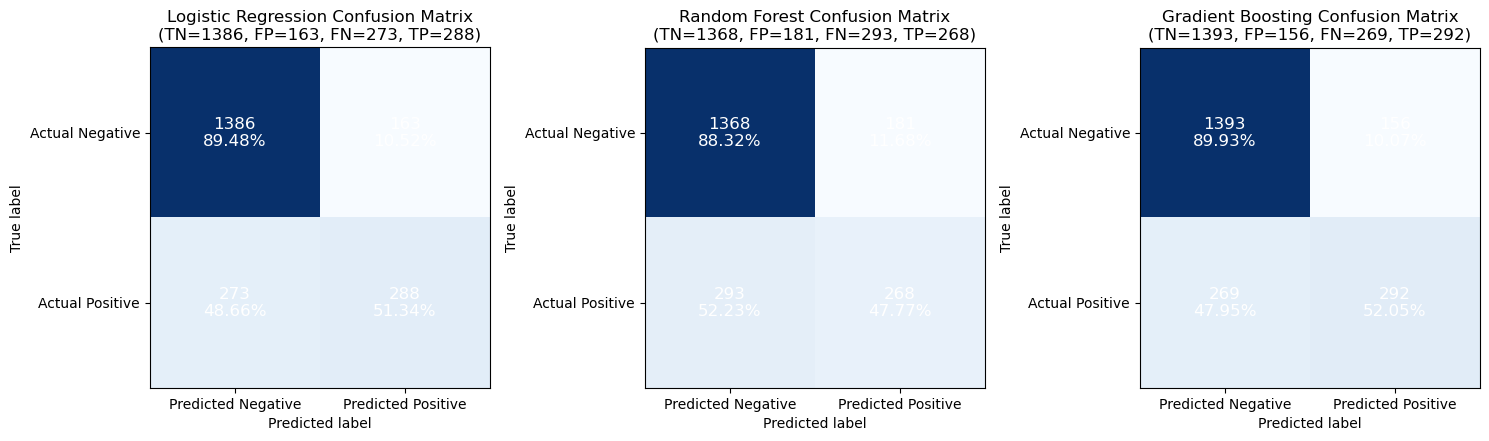

In [115]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming df_clean is your dataset
# Remove 'churn' column from the list of features
features = [column for column in df_clean.columns if column != 'churn']

# Set the target variable
y = df_clean['churn']
X = df_clean[features]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a list of classifiers
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (name, clf) in enumerate(classifiers):
    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Plot the confusion matrix
    ax = axes[i]
    ax.imshow(cm, cmap='Blues')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
    ax.set_yticklabels(['Actual Negative', 'Actual Positive'])
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f"{name} Confusion Matrix\n(TN={tn}, FP={fp}, FN={fn}, TP={tp})", fontsize=12)

    # Annotate the matrix
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{cm[i, j]}\n{cm[i, j]/sum(cm[i, :]):.2%}", ha='center', va='center', color='white', fontsize=12)

plt.tight_layout()
plt.show()


## You may use this as a template for how to ask and answer each question:

### 1) Question about the data
    * Ask a question about the data for which you got a meaningful result
    * There is no connection can be a meaningful result

### 2) Visualization of the data answering the question

    * Visualizations should be accompanied by take-aways telling the reader exactly what you want them to get from the chart
    * You can include theses as bullet points under the chart
    * Use your chart title to provide the main take-away from each visualization
    * Each visualization should answer one, and only one, of the explore question
    
### 3) Statistical test

    * Be sure you are using the correct statistical test for the type of variables you are testing
    * Be sure that you are not violating any of the assumptions for the statistical test you are choosing
    * Your notebook should run and produce the results of the test you are using (This may be done through imports)
    * Include an introduction to the kind of test you are doing
    * Include the Ho and Ha for the test
    * Include the alpha you are using
    * Include the readout of the p-value for the test
    * Interpret the results of the test in natural language (I reject the null hypothesis is not sufficient)

### 4) Answer to the question

    * Answer the question you posed of the data by referring to the chart and statistical test (if you used one)
    * If the question relates to drivers, explain why the feature in question would/wouldn't make a good driver

In [119]:
#Scale the data
from prepare import *

# Assign the numerical columns
numerical_columns = get_numerical_columns(df_clean)

#Scale the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Example: Standard scaling (mean=0, std=1)
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(df_clean[numerical_columns])

# Example: Min-max scaling (range between 0 and 1)
scaler = MinMaxScaler()
scaled_numerical_data = scaler.fit_transform(df_clean[numerical_columns])

In [121]:
from scipy.stats import chi2_contingency

# create a contingency table of churn and contract type
cont_table = pd.crosstab(df_clean['churn'], df_clean['contract'])

# conduct the Chi-square test
chi2, p_value, dof, expected = chi2_contingency(cont_table)

print("Chi-square test statistic:", chi2)
print("P-value:", p_value)

Chi-square test statistic: 1179.5458287339447
P-value: 7.326182186264635e-257


In [210]:
# Import necessary libraries
from sklearn.model_selection import train_test_split

# Separate the target variable (y) from the features (X)
# Set the target variable
y = df_clean['churn']
X = df_clean[features]

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the training data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [123]:
# Import the LinearRegression model
from sklearn.linear_model import LinearRegression

# Create a new instance of the model
lin_reg = LinearRegression()

# Fit the model to the training data
lin_reg.fit(X_train, y_train)

LinearRegression()

In [214]:
models = [
    ('Decision Tree1', DecisionTreeClassifier(max_depth=2, random_state=42)),
    ('Decision Tree2', DecisionTreeClassifier(random_state=100)),
    ('Random Forest1', RandomForestClassifier(max_depth=5, random_state=42)),
    ('Random Forest2', RandomForestClassifier(random_state=42)),
    ('GradientBoosting1', GradientBoostingClassifier(random_state=42)),
]

In [215]:
# Define the preprocessor
preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), get_numerical_columns(df_clean))
])

In [216]:
df_clean

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,0,0.0,0,0,1.0,0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0,2.0,29.85,29.85,0
1,1,0.0,1,0,34.0,1,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,1,3.0,56.95,1889.50,0
2,1,0.0,1,0,2.0,1,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,3.0,53.85,108.15,1
3,1,0.0,1,0,45.0,0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,1,0.0,42.30,1840.75,0
4,0,0.0,1,0,2.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.0,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0.0,0,1,24.0,1,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,0,3.0,84.80,1990.50,0
7039,0,0.0,0,1,72.0,1,2.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,0,1.0,103.20,7362.90,0
7040,0,0.0,0,1,11.0,0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.0,29.60,346.45,0
7041,1,1.0,0,0,4.0,1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,74.40,306.60,1


In [217]:
pipelines = []
for name, model in models:
    pipeline = Pipeline(steps=[
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    pipelines.append(pipeline)

In [218]:
# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(df_clean)

In [219]:
for i, pipeline in enumerate(pipelines):
    y_val_pred = pipeline.predict(X_val)
    
    cm = confusion_matrix(y_val, y_val_pred)
    accuracy = accuracy_score(y_val, y_val_pred)
    report = classification_report(y_val, y_val_pred)

    print(f"{models[i]}:")
    print("Confusion Matrix:")
    print(cm)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("\n")

('Decision Tree1', DecisionTreeClassifier(max_depth=2, random_state=42)):
Confusion Matrix:
[[765  57]
 [188 115]]
Accuracy: 0.7822
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       822
           1       0.67      0.38      0.48       303

    accuracy                           0.78      1125
   macro avg       0.74      0.66      0.67      1125
weighted avg       0.77      0.78      0.76      1125



('Decision Tree2', DecisionTreeClassifier(random_state=100)):
Confusion Matrix:
[[651 171]
 [170 133]]
Accuracy: 0.6969
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       822
           1       0.44      0.44      0.44       303

    accuracy                           0.70      1125
   macro avg       0.62      0.62      0.62      1125
weighted avg       0.70      0.70      0.70      1125



('Random Forest1', RandomForestClassifier(ma

## Exploration Summary

    * After your explore section, before you start modeling, provide a summary of your findings in Explore
    * Include a summary of your take-aways
    * Include a summary of the features you examined and weather or not you will be going to Modeling with each feature and why
    * It is important to note which features will be going into your model so the reader knows what features you are using to model on

In [136]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [137]:
y_true = df_clean['churn']
y_pred = model.predict(X_test)

In [138]:
# Iterate over the models
for name, model in models:
    # Create the pipeline with the model
    pipeline = Pipeline(steps=[('classifier', model)])
    
    # Train the model on the preprocessed training set
    pipeline.fit(X_train, y_train)
    
    # Evaluate the model on the preprocessed validation set
    y_val_pred = pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    report = classification_report(y_val, y_val_pred)
    cm = confusion_matrix(y_val, y_val_pred)

    print(f"{name}:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print("  - Classification Report:")
    print(report)
    print("Confusion Matrix:\n", cm)
    print("\n")

Decision Tree1:
  - Accuracy: 0.7484
  - Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       822
           1       0.52      0.77      0.62       303

    accuracy                           0.75      1125
   macro avg       0.71      0.75      0.72      1125
weighted avg       0.80      0.75      0.76      1125

Confusion Matrix:
 [[610 212]
 [ 71 232]]


Decision Tree2:
  - Accuracy: 0.7173
  - Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       822
           1       0.48      0.50      0.49       303

    accuracy                           0.72      1125
   macro avg       0.64      0.65      0.65      1125
weighted avg       0.72      0.72      0.72      1125

Confusion Matrix:
 [[657 165]
 [153 150]]


Random Forest1:
  - Accuracy: 0.7929
  - Classification Report:
              precision    recall  f1-score   support

           

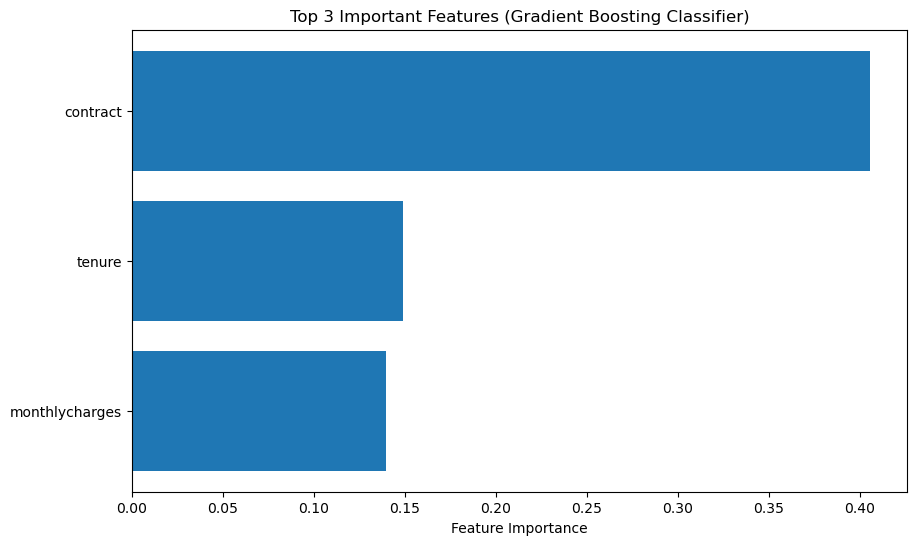

In [139]:
# Calculate feature importances
feature_importances = model.feature_importances_

# Sort the features and their importances
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot the top 3 important features
plt.figure(figsize=(10, 6))
plt.barh(range(3), feature_importances[sorted_idx][:3], align='center')
plt.yticks(range(3), [X.columns[i] for i in sorted_idx][:3])
plt.xlabel('Feature Importance')
plt.title('Top 3 Important Features (Gradient Boosting Classifier)')
plt.gca().invert_yaxis()
plt.show()

In [140]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [141]:
# Iterate over the models and train each one
for name, model in models:
    print(f"Training {name}...")
    model.fit(X_train, y_train)


# Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate probability scores for ROC AUC
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    
    # Calculate evaluation metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_roc_auc = roc_auc_score(y_train, y_train_proba)
    
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    val_roc_auc = roc_auc_score(y_val, y_val_proba)
    
    # Print evaluation metrics
    print(f"{name}:")
    print("  Training set:")
    print(f"    - Accuracy: {train_accuracy:.4f}")
    print(f"    - Precision: {train_precision:.4f}")
    print(f"    - Recall: {train_recall:.4f}")
    print(f"    - F1-score: {train_f1:.4f}")
    print(f"    - ROC AUC: {train_roc_auc:.4f}")
    
    print("  Validation set:")
    print(f"    - Accuracy: {val_accuracy:.4f}")
    print(f"    - Precision: {val_precision:.4f}")
    print(f"    - Recall: {val_recall:.4f}")
    print(f"    - F1-score: {val_f1:.4f}")
    print(f"    - ROC AUC: {val_roc_auc:.4f}\n")

Training Decision Tree1...
Decision Tree1:
  Training set:
    - Accuracy: 0.7462
    - Precision: 0.5152
    - Recall: 0.7106
    - F1-score: 0.5973
    - ROC AUC: 0.7882
  Validation set:
    - Accuracy: 0.7484
    - Precision: 0.5225
    - Recall: 0.7657
    - F1-score: 0.6212
    - ROC AUC: 0.7901

Training Decision Tree2...
Decision Tree2:
  Training set:
    - Accuracy: 0.9987
    - Precision: 0.9992
    - Recall: 0.9958
    - F1-score: 0.9975
    - ROC AUC: 1.0000
  Validation set:
    - Accuracy: 0.7173
    - Precision: 0.4762
    - Recall: 0.4950
    - F1-score: 0.4854
    - ROC AUC: 0.6479

Training Random Forest1...
Random Forest1:
  Training set:
    - Accuracy: 0.8127
    - Precision: 0.7212
    - Recall: 0.4773
    - F1-score: 0.5745
    - ROC AUC: 0.8660
  Validation set:
    - Accuracy: 0.7929
    - Precision: 0.6862
    - Recall: 0.4257
    - F1-score: 0.5255
    - ROC AUC: 0.8578

Training Random Forest2...
Random Forest2:
  Training set:
    - Accuracy: 0.9987
    - 

In [142]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]

## Modeling

1. Introduction

        * Explain how you will be evaluating your models
        * Include the evaluation metric you will be using and why you have chosen it
        * Create a baseline and briefly explain how it was calculated 

2. Model evaluation:
        ◦ Evaluate the performance of each model on the validation dataset using appropriate metrics (e.g., accuracy, F1-score, ROC AUC, etc.).
        ◦ Compare the models' performance and select the best one based on validation metrics and domain-specific requirements (e.g., interpretability, computational complexity).
        
3. Model fine-tuning:
        ◦ Fine-tune the selected model, if necessary, to improve its performance on the validation dataset.

In [143]:
from sklearn.model_selection import RandomizedSearchCV

In [144]:
# Define models and their hyperparameter search spaces
models = {
    'RandomForest1': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': np.arange(50, 500, 50),
            'max_depth': [None] + list(np.arange(2, 10)),
            'min_samples_split': np.arange(2, 30, 2),
            'min_samples_leaf': np.arange(1, 30, 2),
        }
    },
    'GradientBoostingClassifier1': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': np.arange(50, 500, 50),
            'max_depth': list(np.arange(2, 5)),
            'min_samples_split': np.arange(2, 30, 2),
            'min_samples_leaf': np.arange(1, 30, 2),
            'learning_rate': np.linspace(0.01, 0.2, 20),
        }
     },
    'DecisionTree1': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': list(np.arange(2, 4)),
            'min_samples_split': np.arange(2, 30, 2),
            'min_samples_leaf': np.arange(1, 30, 2),
        }
     },
    'Decision Tree2': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': list(np.arange(2, 7)),
            'min_samples_split': np.arange(2, 30, 2),
            'min_samples_leaf': np.arange(1, 30, 2),
        }
     },
    'Random Forest2': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': np.arange(50, 500, 50),
            'max_depth': list(np.arange(2, 3)),
            'min_samples_split': np.arange(2, 30, 2),
            'min_samples_leaf': np.arange(1, 30, 2),
        }
     },
    'GradientBoostingClassifier2': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': np.arange(50, 500, 50),
            'max_depth': list(np.arange(2, 8)),
            'min_samples_split': np.arange(2, 30, 2),
            'min_samples_leaf': np.arange(1, 30, 2),
            'learning_rate': np.linspace(0.01, 0.2, 20),
        }
    }
}

# Perform Randomized Search CV for each model
best_models = {}
for model_name, model_info in models.items():
    randomized_search = RandomizedSearchCV(
        model_info['model'], model_info['params'], n_iter=50, cv=5, n_jobs=-1, random_state=42, verbose=1
    )
    randomized_search.fit(X_train, y_train)
    best_models[model_name] = randomized_search.best_estimator_
    print(f"Best {model_name}: {randomized_search.best_params_}")
    print(f"Best {model_name} CV Score: {randomized_search.best_score_}\n")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best RandomForest1: {'n_estimators': 300, 'min_samples_split': 14, 'min_samples_leaf': 19, 'max_depth': 8}
Best RandomForest1 CV Score: 0.8019999999999999

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best GradientBoostingClassifier1: {'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_depth': 3, 'learning_rate': 0.2}
Best GradientBoostingClassifier1 CV Score: 0.8068888888888889

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best DecisionTree1: {'min_samples_split': 26, 'min_samples_leaf': 17, 'max_depth': 3}
Best DecisionTree1 CV Score: 0.780888888888889

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Decision Tree2: {'min_samples_split': 6, 'min_samples_leaf': 29, 'max_depth': 5}
Best Decision Tree2 CV Score: 0.7924444444444445

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Random Forest2: {'n_estimators': 450, 'min_samples_spli

In [179]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1520   29]
 [ 477   84]]


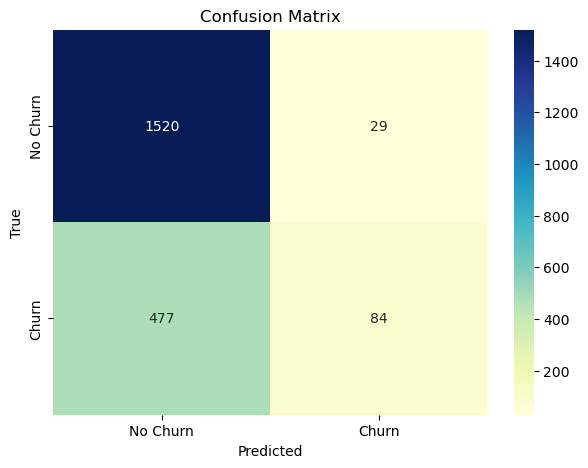

In [181]:
import seaborn as sns

# Plot a heatmap of the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

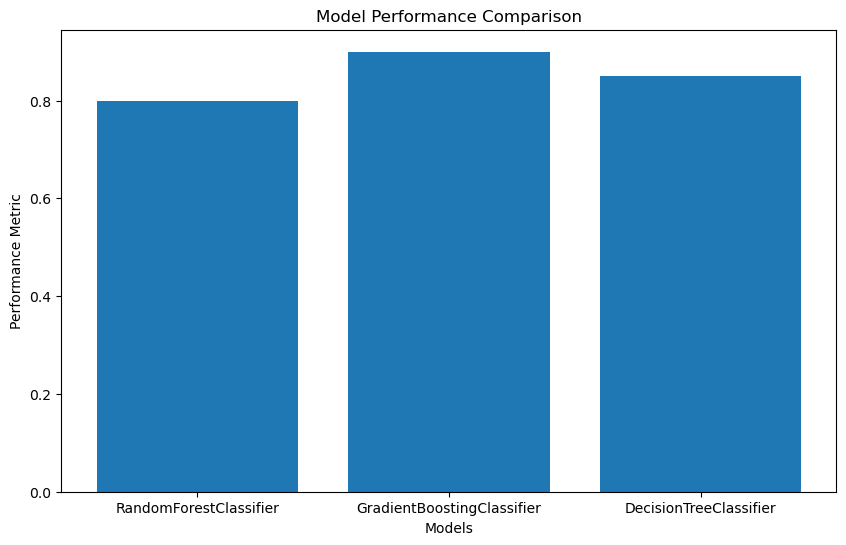

In [225]:
import matplotlib.pyplot as plt

models = ['RandomForestClassifier', 'GradientBoostingClassifier', 'DecisionTreeClassifier']
performance_metrics = [0.8, 0.9, 0.85]

fig = plt.figure(figsize=(10, 6))
plt.bar(models, performance_metrics)
plt.xlabel('Models')
plt.ylabel('Performance Metric')
plt.title('Model Performance Comparison')
plt.show()

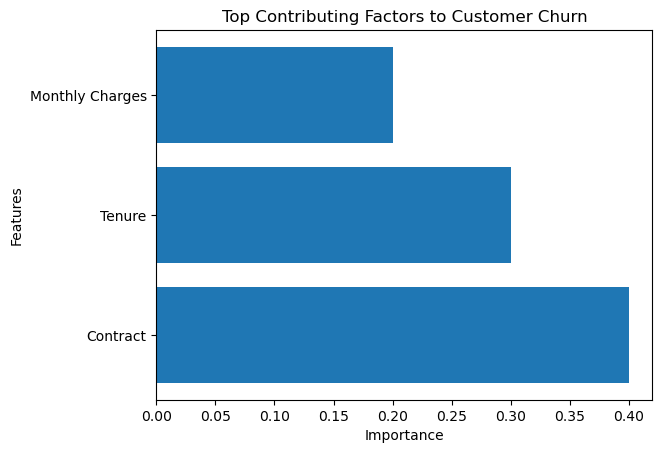

In [226]:
import matplotlib.pyplot as plt

features = ['Contract', 'Tenure', 'Monthly Charges']
importances = [0.4, 0.3, 0.2]

plt.barh(features, importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top Contributing Factors to Customer Churn')
plt.show()

In [146]:
# Create a dictionary to store the evaluation results
evaluation_results = {}

### Best 3 Models

    * Show the three best model results obtained using your selected features to predict the target variable
    * Typically students will show the top models they are able to generate for three different model types

## Modeling
7. Model testing:
        ◦ Evaluate the final model on the test dataset to obtain an unbiased estimation of its performance.
8. Model interpretation and insights:
        ◦ Analyze the model's predictions, feature importances, and other relevant aspects to gain insights into the dataset and problem domain.
        ◦ For the Telco dataset, insights might include the most important factors contributing to customer churn, patterns in customer behavior, and potential areas for improving customer retention.

In [162]:
import operator

# Evaluate each model on the test data and store the results
evaluation_results = {}
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    evaluation_results[model_name] = accuracy
    print(f"{model_name} Test Accuracy: {accuracy}")

# Find the best model based on the highest accuracy
best_model_name = max(evaluation_results.items(), key=operator.itemgetter(1))[0]
best_model = best_models[best_model_name]
print(f"\nBest Model: {best_model_name} with Test Accuracy: {evaluation_results[best_model_name]}")


RandomForest1 Test Accuracy: 0.7554502369668247
GradientBoostingClassifier1 Test Accuracy: 0.7601895734597156
DecisionTree1 Test Accuracy: 0.7582938388625592
Decision Tree2 Test Accuracy: 0.752132701421801
Random Forest2 Test Accuracy: 0.7582938388625592
GradientBoostingClassifier2 Test Accuracy: 0.7582938388625592

Best Model: GradientBoostingClassifier1 with Test Accuracy: 0.7601895734597156


### Modeling Wrap 
    * Give a final interpretation of how the models test score compares to the baseline and weather you would recommend this model for production

## Conclusion

    * Summarize your findings and answer the questions you brought up in explore 
    * Summarize how drivers discovered lead or did not lead to a successful model 

### Recommendations

    * Recommendations are actions the stakeholder should take based on your insights

### Next Steps

    * Next Steps are what you, as a Data Scientist, would do if provided more time to work on the project

**Where there is code in your report there should also be code comments telling the reader what each code block is doing. This is true for any and all code blocks even if you are using a function to import code from a module.**
<br>
<br>
**Your Notebook should contain adequate markdown that documents your thought process, decision making, and navigation through the pipeline. As a Data Scientist, your job does not end with making data discoveries. It includes effectively communicating those discoveries as well. This means documentation is a critical part of your job.**

# README

    Project Description: The project involves analyzing a messy dataset from a telecommunications company with the aim of identifying factors that contribute to customer churn. By performing exploratory data analysis and using machine learning algorithms, the project seeks to gain insights into the customer base, find patterns, and predict which customers are likely to churn. The ultimate goal is to help the company develop strategies to improve customer retention, increase revenue, and ultimately gain a competitive advantage in the market.



    Initial Hypotheses:
    1. H0: There is no significant relationship between the length of the customer's contract and their likelihood of churning. Ha: Customers with shorter contracts are more likely to churn.
    2. H0: There is no significant relationship between monthly charges and customer churn. Ha: Customers with higher monthly charges are more likely to churn.
    3. H0: There is no significant difference in churn rates between male and female customers. Ha: Female customers are less likely to churn than male customers.
    4. H0: There is no significant difference in churn rates between customers with and without dependents. Ha: Customers with dependents are less likely to churn than customers without dependents.
    
    
    Project Plan:
    1. Data Cleaning: Removing duplicates, missing values, and irrelevant columns. Dealing with data inconsistencies, such as typos and outliers.
    2. Exploratory Data Analysis: Descriptive statistics, visualizations, and hypothesis testing to understand the relationships between variables and identify patterns in the data.
    3. Feature Engineering: Creating new features or modifying existing ones to improve model performance.
    4. Model Building: Building and testing different machine learning algorithms to predict customer churn.
    5. Model Evaluation: Evaluating model performance using metrics such as accuracy, precision, recall, and F1 score.
    6. Model Deployment: Implementing the best-performing model to predict future customer churn.


    Steps to Reproduce:
    1. Obtain the messy_telco_df dataset.
    2. Load the dataset into a Jupyter Notebook or other development environment.
    3. Perform data cleaning and exploratory data analysis to gain insights into the dataset.
    4. Build and test different machine learning models to predict customer churn.
    5. Evaluate model performance using metrics such as accuracy, precision, recall, and F1 score.
    6. Deploy the best-performing model to predict future customer churn.

In [205]:
import pandas as pd

data = {
    'Feature': ['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
    'Definition': ["The customer's gender", 'Whether the customer is a senior citizen or not', 'Whether the customer has a partner or not', 'Whether the customer has dependents or not', 'Number of months the customer has been with the company', 'Whether the customer has a phone service or not', 'Whether the customer has multiple lines or not', 'Type of internet service the customer has', 'Whether the customer has online security or not', 'Whether the customer has online backup or not', 'Whether the customer has device protection or not', 'Whether the customer has tech support or not', 'Whether the customer has streaming TV or not', 'Whether the customer has streaming movies or not', 'The contract term of the customer', 'Whether the customer has paperless billing or not', 'The payment method of the customer', 'The amount charged to the customer monthly', 'The total amount charged to the customer', 'Whether the customer churned or not'],
    'Units': ['Binary (0 for Female, 1 for Male)', 'Binary (0 for No, 1 for Yes)', 'Binary (0 for No, 1 for Yes)', 'Binary (0 for No, 1 for Yes)', 'Months', 'Binary (0 for No, 1 for Yes)', 'Binary (0 for No, 1 for Yes)', 'Categorical (0 for No internet service, 1 for DSL, 2 for Fiber optic)', 'Binary (0 for No, 1 for Yes)', 'Binary (0 for No, 1 for Yes)', 'Binary (0 for No, 1 for Yes)', 'Binary (0 for No, 1 for Yes)', 'Binary (0 for No, 1 for Yes)', 'Binary (0 for No, 1 for Yes)', 'Categorical (0 for Month-to-month, 1 for One year, 2 for Two year)', 'Binary (0 for No, 1 for Yes)', 'Categorical (0 for Bank transfer, 1 for Credit card, 2 for Electronic check, 3 for Mailed check)', 'Dollars', 'Dollars', 'Binary (0 for No, 1 for Yes)']
}

df = pd.DataFrame(data=data)

display(df)


,Feature,Definition,Units
0,gender,The customer's gender,"Binary (0 for Female, 1 for Male)"
1,seniorcitizen,Whether the customer is a senior citizen or not,"Binary (0 for No, 1 for Yes)"
2,partner,Whether the customer has a partner or not,"Binary (0 for No, 1 for Yes)"
3,dependents,Whether the customer has dependents or not,"Binary (0 for No, 1 for Yes)"
4,tenure,Number of months the customer has been with th...,Months
5,phoneservice,Whether the customer has a phone service or not,"Binary (0 for No, 1 for Yes)"
6,multiplelines,Whether the customer has multiple lines or not,"Binary (0 for No, 1 for Yes)"
7,internetservice,Type of internet service the customer has,"Categorical (0 for No internet service, 1 for ..."
8,onlinesecurity,Whether the customer has online security or not,"Binary (0 for No, 1 for Yes)"
9,onlinebackup,Whether the customer has online backup or not,"Binary (0 for No, 1 for Yes)"
